In [1]:
# tool
import os
import pandas as pd
import matplotlib.pyplot as plt
from utilsforecast.plotting import plot_series
from statsforecast import StatsForecast

# forecast
from neuralforecast import NeuralForecast

# models
from neuralforecast.models import NHITS

import torch
torch.set_float32_matmul_precision('medium')

# log
import logging
logging.getLogger("pytorch_lightning").setLevel(logging.INFO)

# env vars
os.environ["NIXTLA_ID_AS_COL"] = "1"
os.environ["PL_DISABLE_FORK"] = "1"

# data

In [2]:
Y_df = pd.read_parquet('https://datasets-nixtla.s3.amazonaws.com/m4-hourly.parquet')
Y_df = Y_df.query("unique_id == 'H1'")[:700]
print(Y_df.head(), "\n")
print(Y_df.shape, "\n")
print(Y_df["unique_id"].value_counts())

  unique_id  ds      y
0        H1   1  605.0
1        H1   2  586.0
2        H1   3  586.0
3        H1   4  559.0
4        H1   5  511.0 

(700, 3) 

unique_id
H1    700
Name: count, dtype: int64


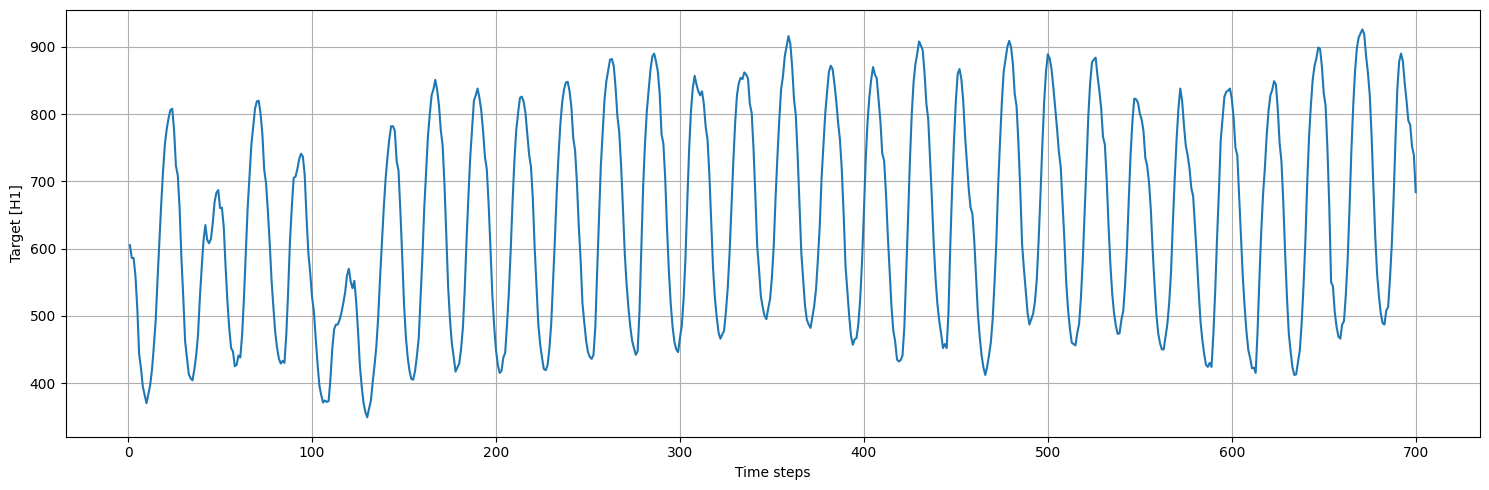

In [3]:
plt.figure(figsize = (15, 5))
plt.plot(Y_df["ds"], Y_df["y"])
plt.xlabel("Time steps")
plt.ylabel("Target [H1]")
plt.tight_layout()
plt.grid()

In [5]:
# fig = plot_series(Y_df, engine="plotly")
# fig

In [6]:
# StatsForecast.plot(Y_df)

# model

In [7]:
h = 100
nf = NeuralForecast(
    models = [
        NHITS(
            h = h, 
            input_size = 2*h, 
            max_steps = 400, 
            enable_progress_bar = False, 
            logger = True
        ),
    ],
    freq = 1,
)

Global seed set to 1


# cross validation

## method 1: `n_windows`

In [28]:
cv_df = nf.cross_validation(
    Y_df,
    n_windows = 4,
    step_size = h, 
    verbose = 0,
)
cv_df

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params
-----------------------------------------------
0 | loss         | MAE           | 0     
1 | padder_train | ConstantPad1d | 0     
2 | scaler       | TemporalNorm  | 0     
3 | blocks       | ModuleList    | 3.0 M 
-----------------------------------------------
3.0 M     Trainable params
0         Non-trainable params
3.0 M     Total params
11.871    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_steps=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


,unique_id,ds,cutoff,NHITS,y
0,H1,301,300,491.270508,485.0
1,H1,302,300,532.598511,525.0
2,H1,303,300,607.920227,585.0
3,H1,304,300,688.494934,670.0
4,H1,305,300,760.984558,747.0
...,...,...,...,...,...
395,H1,696,600,782.493347,790.0
396,H1,697,600,813.855103,784.0
397,H1,698,600,799.327148,752.0
398,H1,699,600,790.941406,739.0


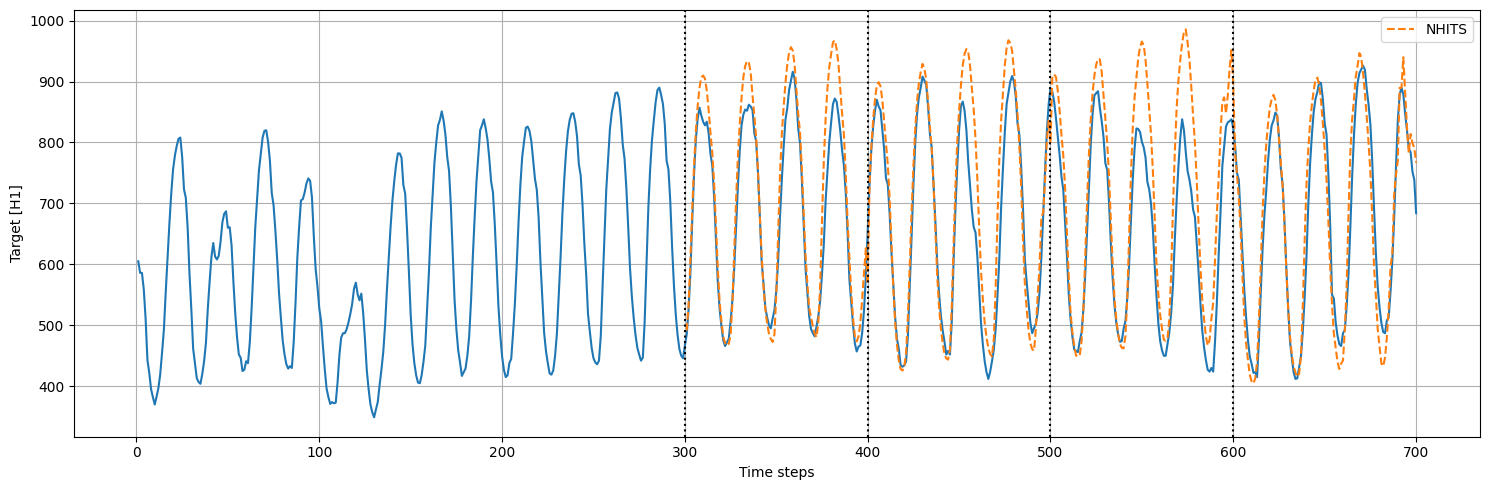

In [30]:
plt.figure(figsize = (15, 5))
plt.plot(Y_df["ds"], Y_df["y"])
plt.plot(cv_df["ds"], cv_df["NHITS"], label = "NHITS", ls = "--")
for cutoff in cv_df["cutoff"].unique():
    plt.axvline(x = cutoff, color = "black", ls = ":")
plt.xlabel("Time steps")
plt.ylabel("Target [H1]")
plt.legend()
plt.tight_layout()
plt.grid()

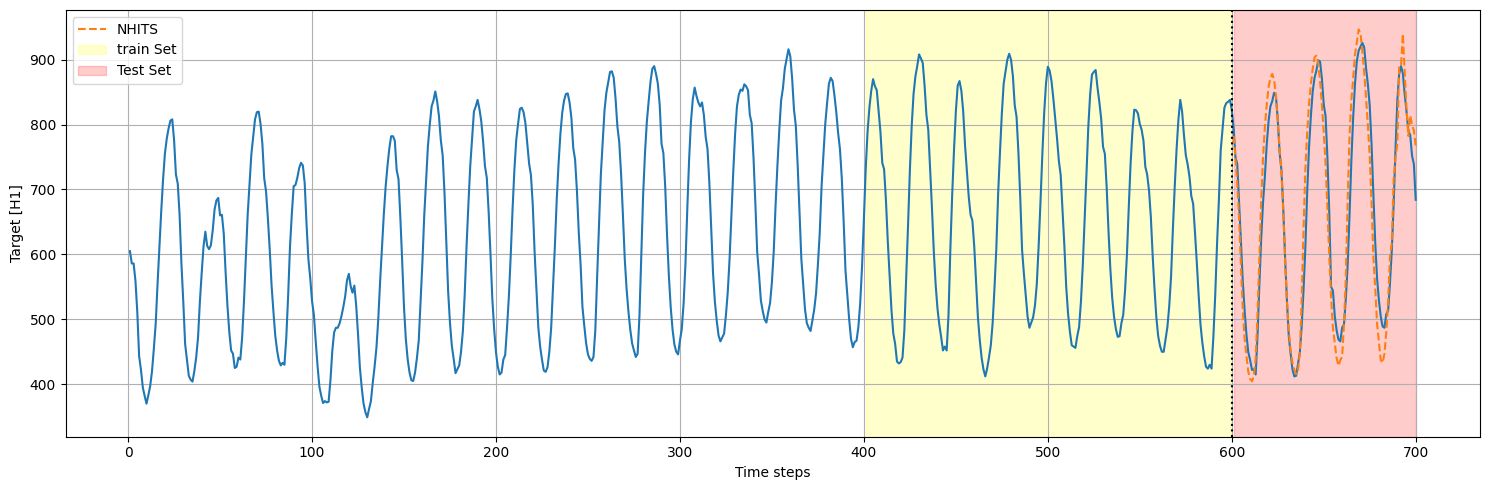

In [31]:
plt.figure(figsize = (15, 5))
# raw series
plt.plot(Y_df["ds"], Y_df["y"])
# predict series
plt.plot(cv_df.loc[cv_df["cutoff"] == 600, "ds"], cv_df.loc[cv_df["cutoff"] == 600, "NHITS"], label = "NHITS", ls = "--")
# Add highlighted areas for validation and test sets
plt.axvspan(Y_df['ds'].iloc[400], Y_df['ds'].iloc[599], alpha=0.2, color='yellow', label='train Set')
plt.axvspan(Y_df['ds'].iloc[600], Y_df['ds'].iloc[699], alpha=0.2, color='red', label='Test Set')
# cutoff
plt.axvline(x = 600, color = "black", ls = ":")
# other setting
plt.xlabel("Time steps")
plt.ylabel("Target [H1]")
plt.legend()
plt.tight_layout()
plt.grid()

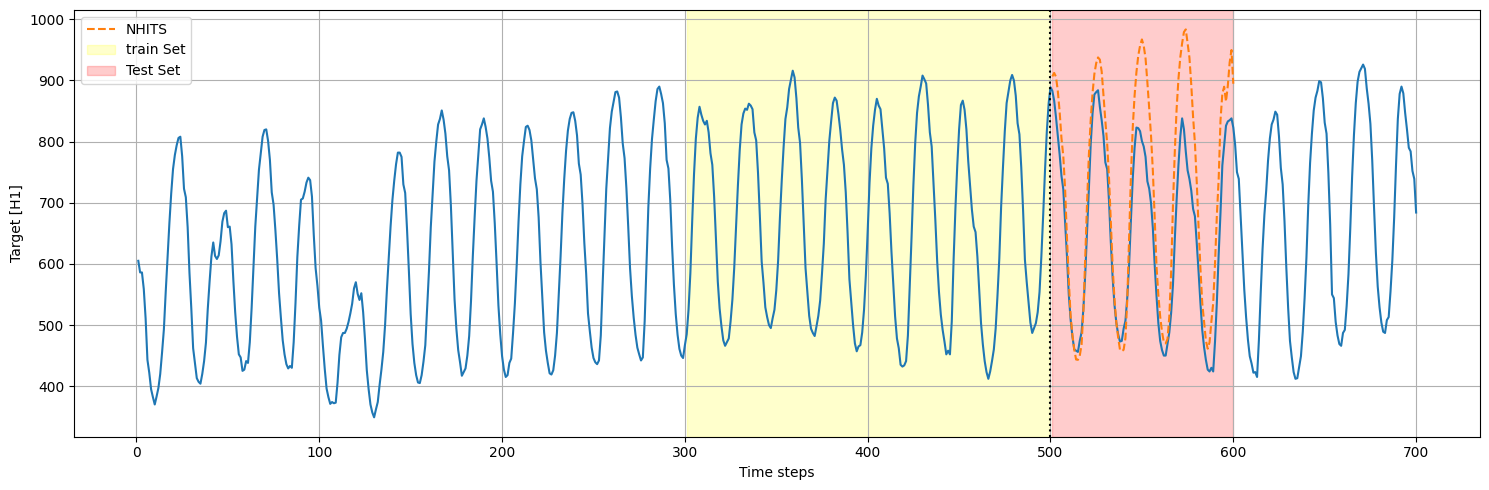

In [15]:
plt.figure(figsize = (15, 5))
# raw series
plt.plot(Y_df["ds"], Y_df["y"])
plt.plot(cv_df.loc[cv_df["cutoff"] == 500, "ds"], cv_df.loc[cv_df["cutoff"] == 500, "NHITS"], label = "NHITS", ls = "--")
# Add highlighted areas for validation and test sets
plt.axvspan(Y_df['ds'].iloc[300], Y_df['ds'].iloc[499], alpha=0.2, color='yellow', label='train Set')
plt.axvspan(Y_df['ds'].iloc[500], Y_df['ds'].iloc[599], alpha=0.2, color='red', label='Test Set')
plt.axvline(x = 500, color = "black", ls = ":")
plt.xlabel("Time steps")
plt.ylabel("Target [H1]")
plt.legend()
plt.tight_layout()
plt.grid()

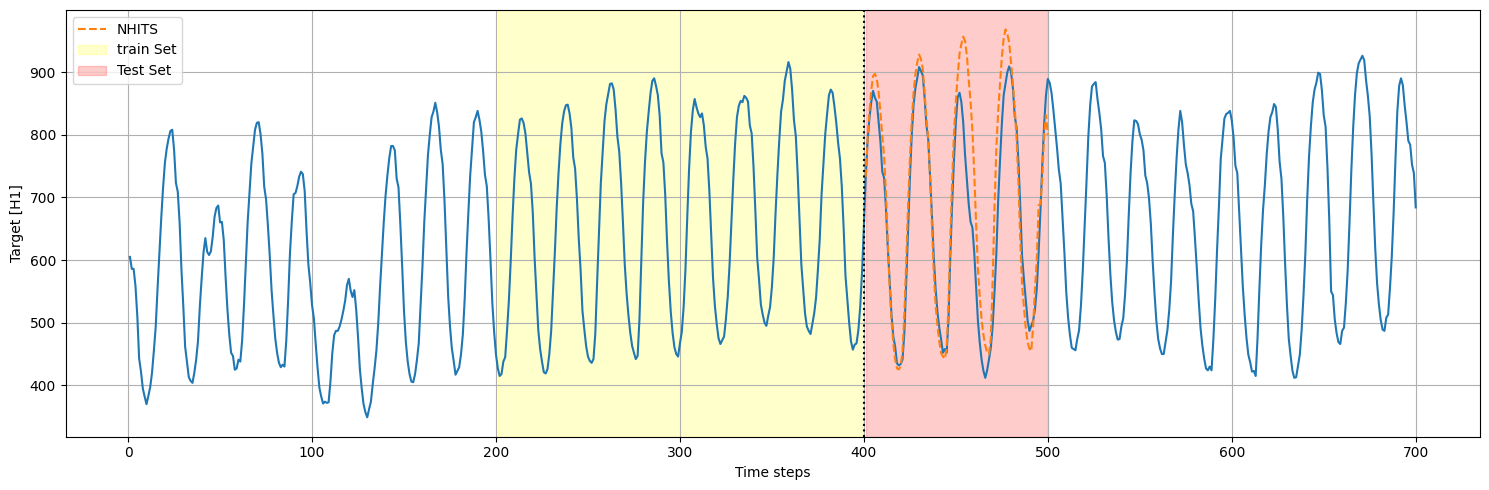

In [16]:
plt.figure(figsize = (15, 5))
# raw series
plt.plot(Y_df["ds"], Y_df["y"])
plt.plot(cv_df.loc[cv_df["cutoff"] == 400, "ds"], cv_df.loc[cv_df["cutoff"] == 400, "NHITS"], label = "NHITS", ls = "--")
# Add highlighted areas for validation and test sets
plt.axvspan(Y_df['ds'].iloc[200], Y_df['ds'].iloc[399], alpha=0.2, color='yellow', label='train Set')
plt.axvspan(Y_df['ds'].iloc[400], Y_df['ds'].iloc[499], alpha=0.2, color='red', label='Test Set')
plt.axvline(x = 400, color = "black", ls = ":")
plt.xlabel("Time steps")
plt.ylabel("Target [H1]")
plt.legend()
plt.tight_layout()
plt.grid()

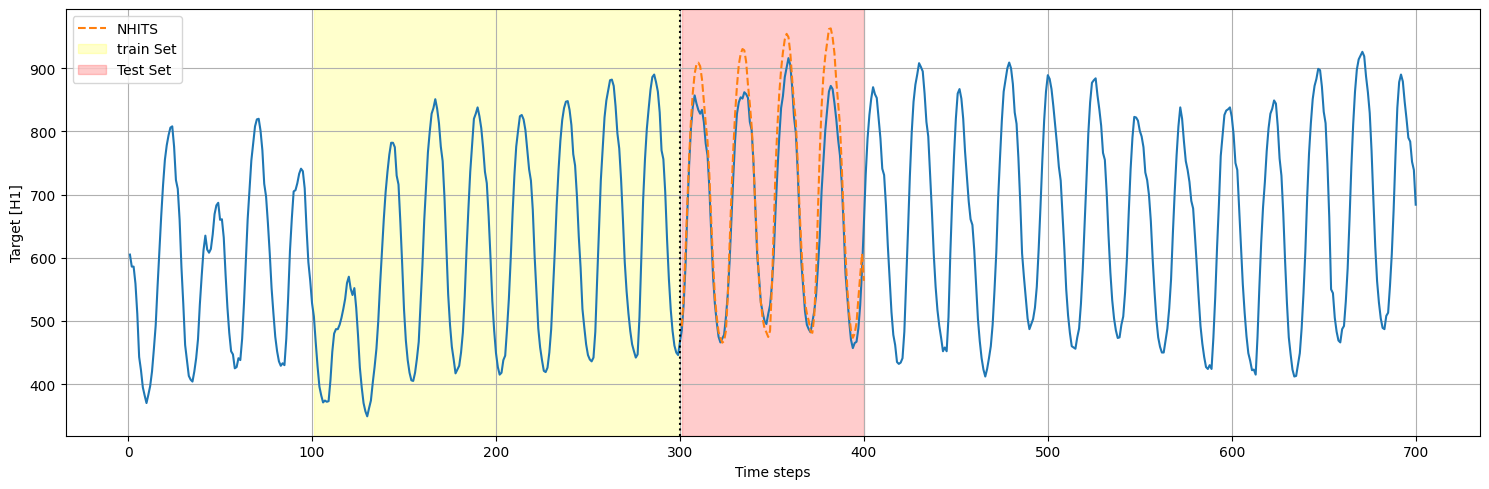

In [17]:
plt.figure(figsize = (15, 5))
# raw series
plt.plot(Y_df["ds"], Y_df["y"])
plt.plot(cv_df.loc[cv_df["cutoff"] == 300, "ds"], cv_df.loc[cv_df["cutoff"] == 300, "NHITS"], label = "NHITS", ls = "--")
# Add highlighted areas for validation and test sets
plt.axvspan(Y_df['ds'].iloc[100], Y_df['ds'].iloc[299], alpha=0.2, color='yellow', label='train Set')
plt.axvspan(Y_df['ds'].iloc[300], Y_df['ds'].iloc[399], alpha=0.2, color='red', label='Test Set')
plt.axvline(x = 300, color = "black", ls = ":")
plt.xlabel("Time steps")
plt.ylabel("Target [H1]")
plt.legend()
plt.tight_layout()
plt.grid()

## method 2: validation & test

In [11]:
cv_df_val_test = nf.cross_validation(
    Y_df, 
    val_size = 200,
    test_size = 200,
    step_size = h, 
    n_windows = None,
)
cv_df_val_test

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params
-----------------------------------------------
0 | loss         | MAE           | 0     
1 | padder_train | ConstantPad1d | 0     
2 | scaler       | TemporalNorm  | 0     
3 | blocks       | ModuleList    | 3.0 M 
-----------------------------------------------
3.0 M     Trainable params
0         Non-trainable params
3.0 M     Total params
11.871    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


,unique_id,ds,cutoff,NHITS,y
0,H1,501,500,910.288025,883.0
1,H1,502,500,914.349182,867.0
2,H1,503,500,910.832275,840.0
3,H1,504,500,889.911926,810.0
4,H1,505,500,849.298096,779.0
...,...,...,...,...,...
195,H1,696,600,805.620605,790.0
196,H1,697,600,836.607056,784.0
197,H1,698,600,882.162109,752.0
198,H1,699,600,879.229309,739.0


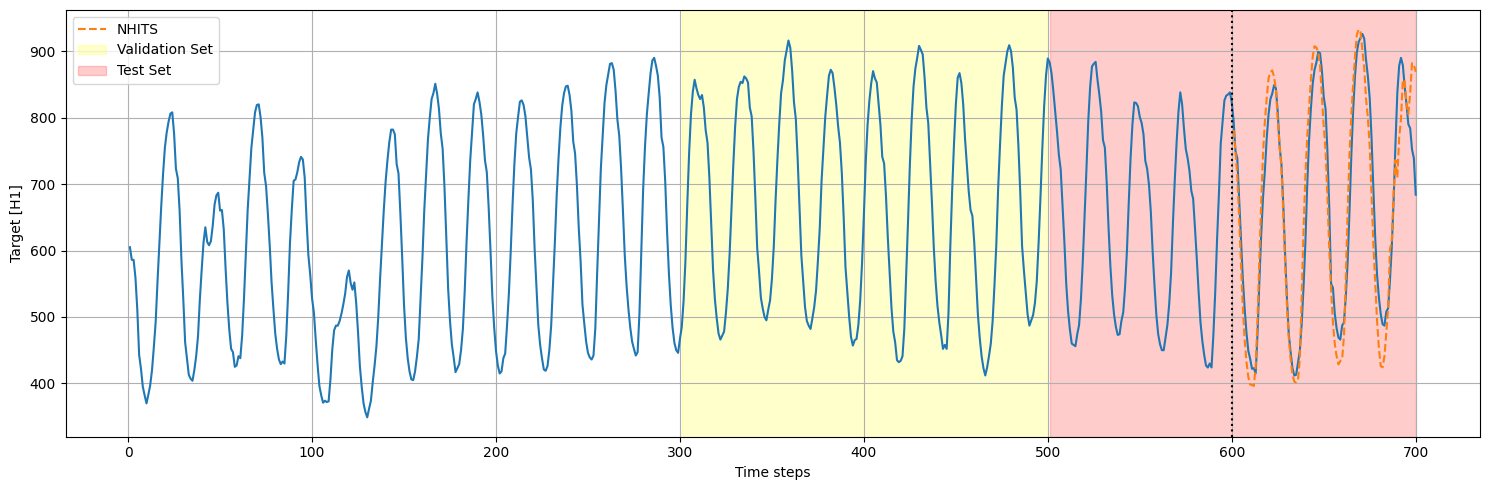

In [20]:
plt.figure(figsize=(15,5))
# Plot the original data and NHITS predictions
plt.plot(Y_df['ds'], Y_df['y'])
plt.plot(cv_df_val_test.loc[cv_df_val_test["cutoff"] == 600, 'ds'], cv_df_val_test.loc[cv_df_val_test["cutoff"] == 600, 'NHITS'], label='NHITS', ls='--')
# Add highlighted areas for validation and test sets
plt.axvspan(Y_df['ds'].iloc[300], Y_df['ds'].iloc[499], alpha=0.2, color='yellow', label='Validation Set')
plt.axvspan(Y_df['ds'].iloc[500], Y_df['ds'].iloc[699], alpha=0.2, color='red', label='Test Set')
# Add vertical lines for cutoffs
plt.axvline(x=600, color='black', ls=':')
# Set labels and legend
plt.xlabel('Time steps')
plt.ylabel('Target [H1]')
plt.legend()
plt.tight_layout()
plt.grid()
plt.show()

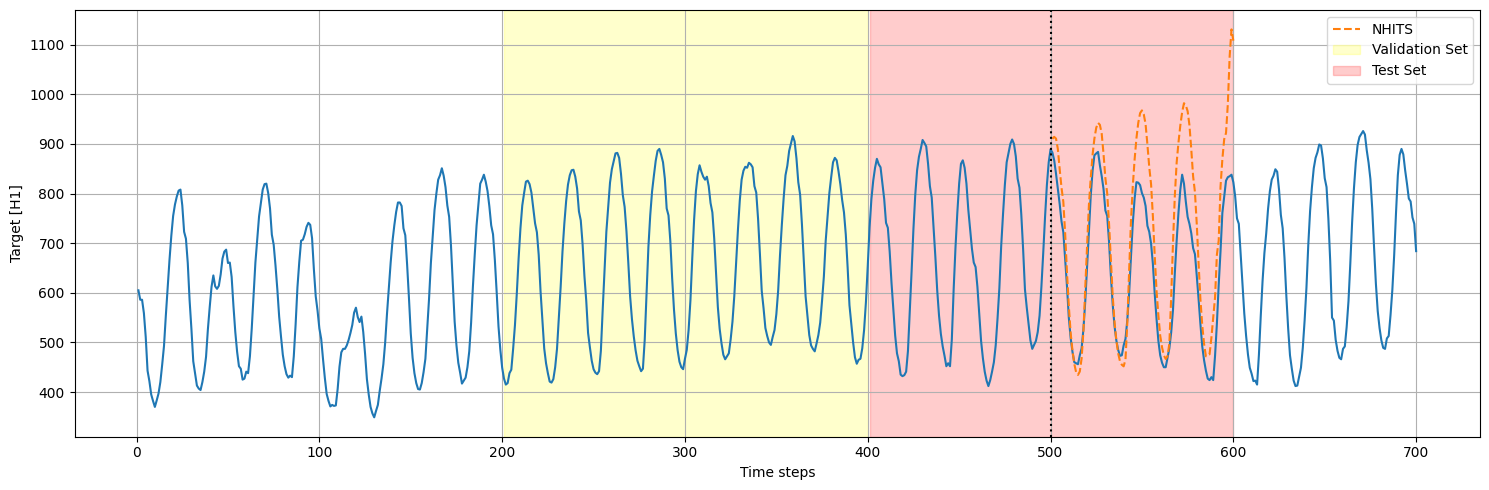

In [21]:
plt.figure(figsize=(15,5))
# Plot the original data and NHITS predictions
plt.plot(Y_df['ds'], Y_df['y'])
plt.plot(cv_df_val_test.loc[cv_df_val_test["cutoff"] == 500, 'ds'], cv_df_val_test.loc[cv_df_val_test["cutoff"] == 500, 'NHITS'], label='NHITS', ls='--')
# Add highlighted areas for validation and test sets
plt.axvspan(Y_df['ds'].iloc[200], Y_df['ds'].iloc[399], alpha=0.2, color='yellow', label='Validation Set')
plt.axvspan(Y_df['ds'].iloc[400], Y_df['ds'].iloc[599], alpha=0.2, color='red', label='Test Set')
# Add vertical lines for cutoffs
plt.axvline(x=500, color='black', ls=':')
# Set labels and legend
plt.xlabel('Time steps')
plt.ylabel('Target [H1]')
plt.legend()
plt.tight_layout()
plt.grid()
plt.show()

## method 3: cross-validation with refit

In [23]:
cv_df_refit = nf.cross_validation(
    Y_df, 
    n_windows=4, 
    step_size=h, 
    refit=True
)
cv_df_refit

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params
-----------------------------------------------
0 | loss         | MAE           | 0     
1 | padder_train | ConstantPad1d | 0     
2 | scaler       | TemporalNorm  | 0     
3 | blocks       | ModuleList    | 3.0 M 
-----------------------------------------------
3.0 M     Trainable params
0         Non-trainable params
3.0 M     Total params
11.871    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU availab

,unique_id,ds,cutoff,NHITS,y
0,H1,301,300,495.953949,485.0
1,H1,302,300,537.489075,525.0
2,H1,303,300,607.804138,585.0
3,H1,304,300,695.272766,670.0
4,H1,305,300,759.966431,747.0
...,...,...,...,...,...
395,H1,696,600,755.964050,790.0
396,H1,697,600,735.323669,784.0
397,H1,698,600,698.859863,752.0
398,H1,699,600,680.500366,739.0


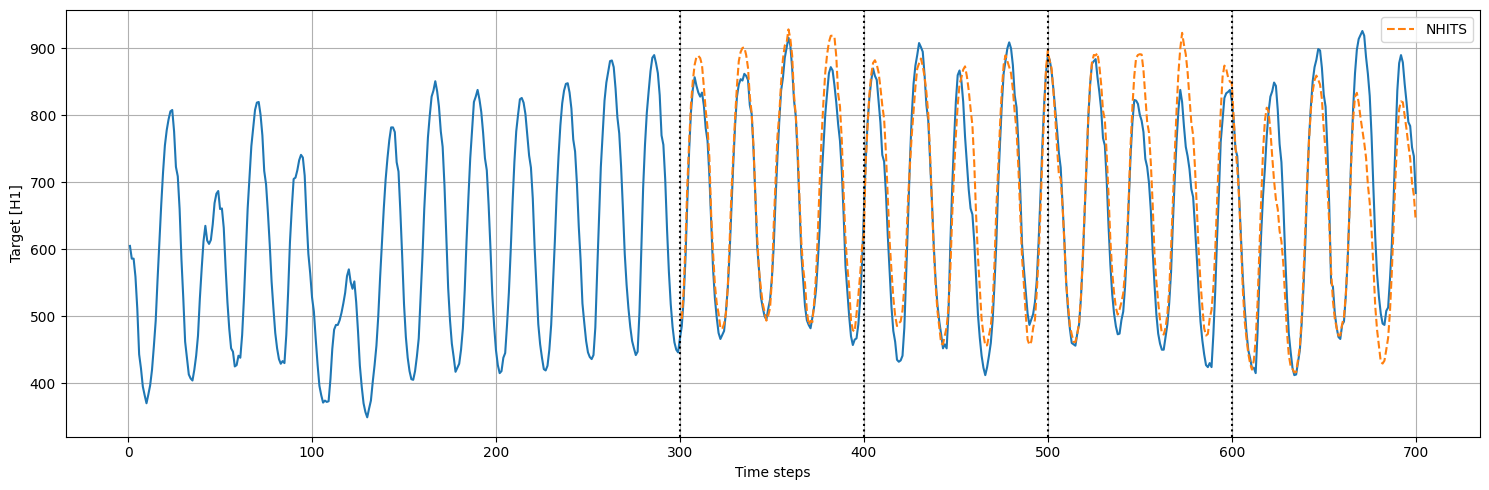

In [25]:
plt.figure(figsize=(15,5))
# raw series
plt.plot(Y_df['ds'], Y_df['y'])
# predict series
plt.plot(cv_df_refit['ds'], cv_df_refit['NHITS'], label='NHITS', ls='--')
# cutoff
for cutoff in cv_df_refit['cutoff'].unique():
    plt.axvline(x=cutoff, color='black', ls=':')
plt.xlabel('Time steps')
plt.ylabel('Target [H1]')
plt.legend()
plt.tight_layout()
plt.grid()

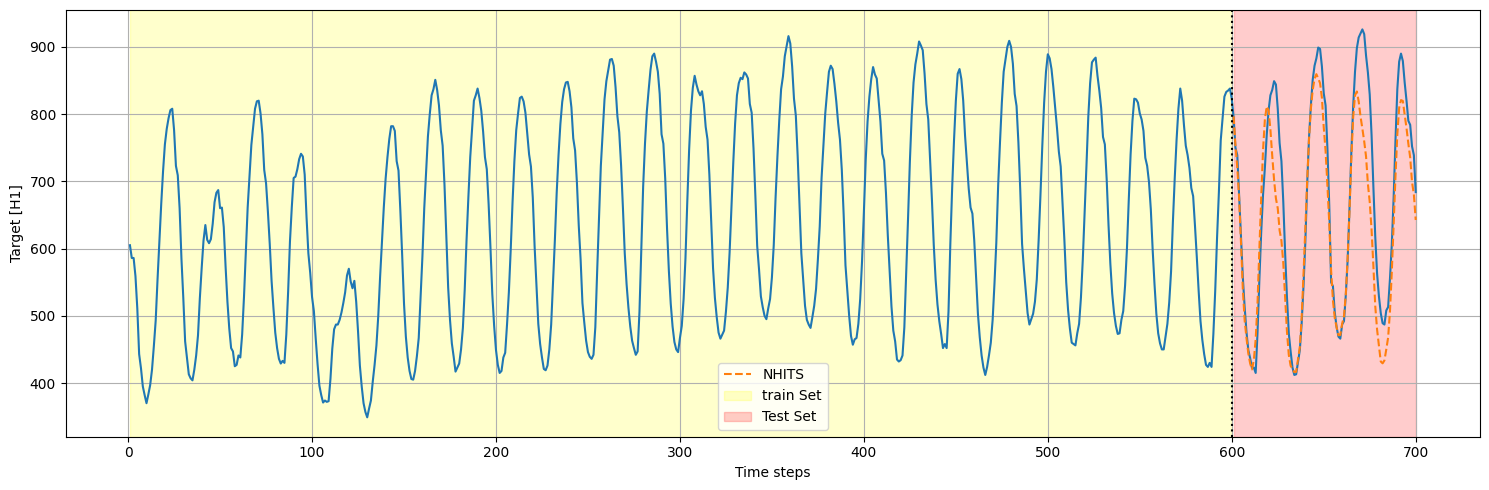

In [34]:
plt.figure(figsize=(15,5))
# raw series
plt.plot(Y_df['ds'], Y_df['y'])
# predict series
plt.plot(cv_df_refit.loc[cv_df_refit["cutoff"] == 600, 'ds'], cv_df_refit.loc[cv_df_refit["cutoff"] == 600, 'NHITS'], label='NHITS', ls='--')
# Add highlighted areas for validation and test sets
plt.axvspan(Y_df['ds'].iloc[0], Y_df['ds'].iloc[599], alpha=0.2, color='yellow', label='train Set')
plt.axvspan(Y_df['ds'].iloc[600], Y_df['ds'].iloc[699], alpha=0.2, color='red', label='Test Set')
# cufoff
plt.axvline(x=600, color='black', ls=':')
plt.xlabel('Time steps')
plt.ylabel('Target [H1]')
plt.legend()
plt.tight_layout()
plt.grid()

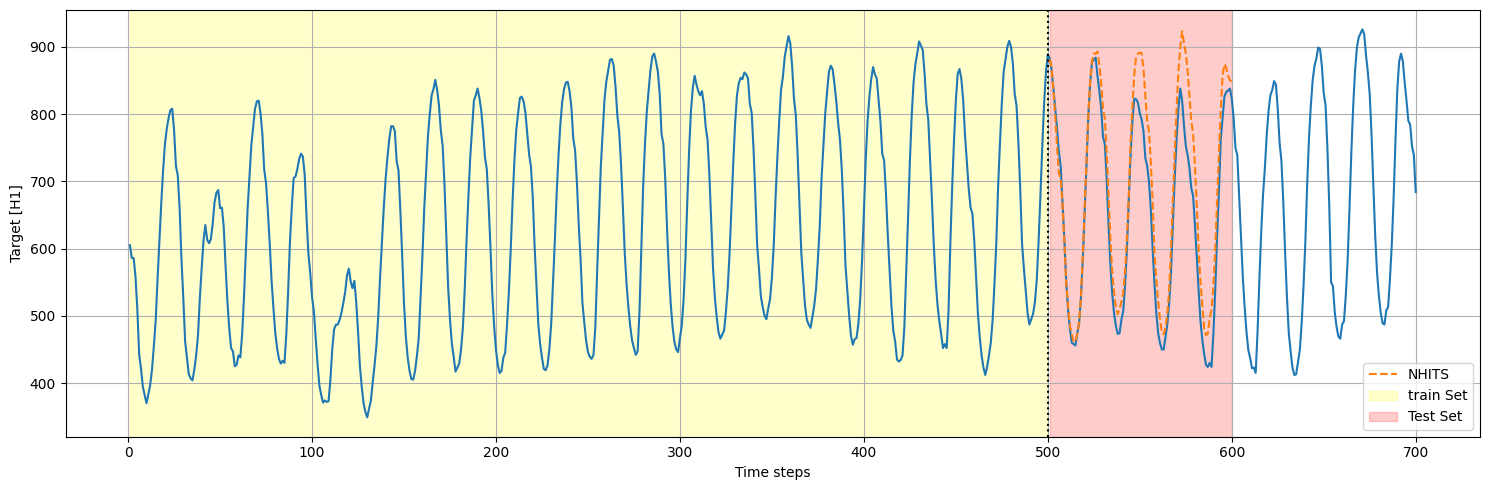

In [33]:
plt.figure(figsize=(15,5))
# raw series
plt.plot(Y_df['ds'], Y_df['y'])
# predict series
plt.plot(cv_df_refit.loc[cv_df_refit["cutoff"] == 500, 'ds'], cv_df_refit.loc[cv_df_refit["cutoff"] == 500, 'NHITS'], label='NHITS', ls='--')
# Add highlighted areas for validation and test sets
plt.axvspan(Y_df['ds'].iloc[0], Y_df['ds'].iloc[499], alpha=0.2, color='yellow', label='train Set')
plt.axvspan(Y_df['ds'].iloc[500], Y_df['ds'].iloc[599], alpha=0.2, color='red', label='Test Set')
# cutoff
plt.axvline(x=500, color='black', ls=':')
plt.xlabel('Time steps')
plt.ylabel('Target [H1]')
plt.legend()
plt.tight_layout()
plt.grid()

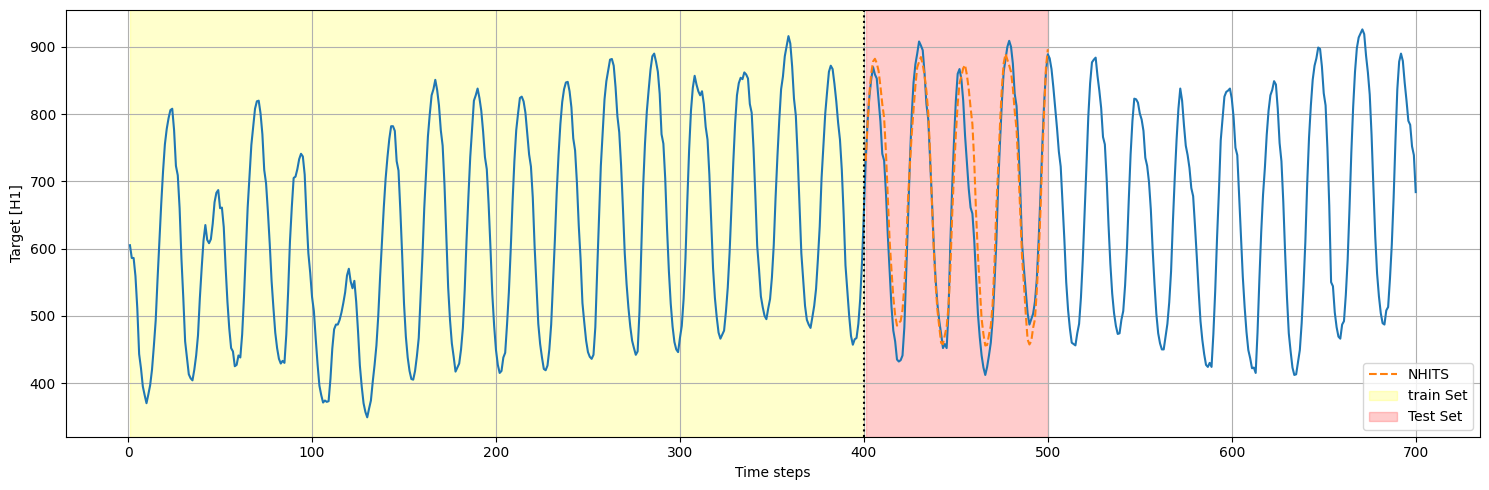

In [32]:
plt.figure(figsize=(15,5))
# raw series
plt.plot(Y_df['ds'], Y_df['y'])
# predict sereis
plt.plot(cv_df_refit.loc[cv_df_refit["cutoff"] == 400, 'ds'], cv_df_refit.loc[cv_df_refit["cutoff"] == 400, 'NHITS'], label='NHITS', ls='--')
# Add highlighted areas for validation and test sets
plt.axvspan(Y_df['ds'].iloc[0], Y_df['ds'].iloc[399], alpha=0.2, color='yellow', label='train Set')
plt.axvspan(Y_df['ds'].iloc[400], Y_df['ds'].iloc[499], alpha=0.2, color='red', label='Test Set')
# cutoff
plt.axvline(x=400, color='black', ls=':')
plt.xlabel('Time steps')
plt.ylabel('Target [H1]')
plt.legend()
plt.tight_layout()
plt.grid()

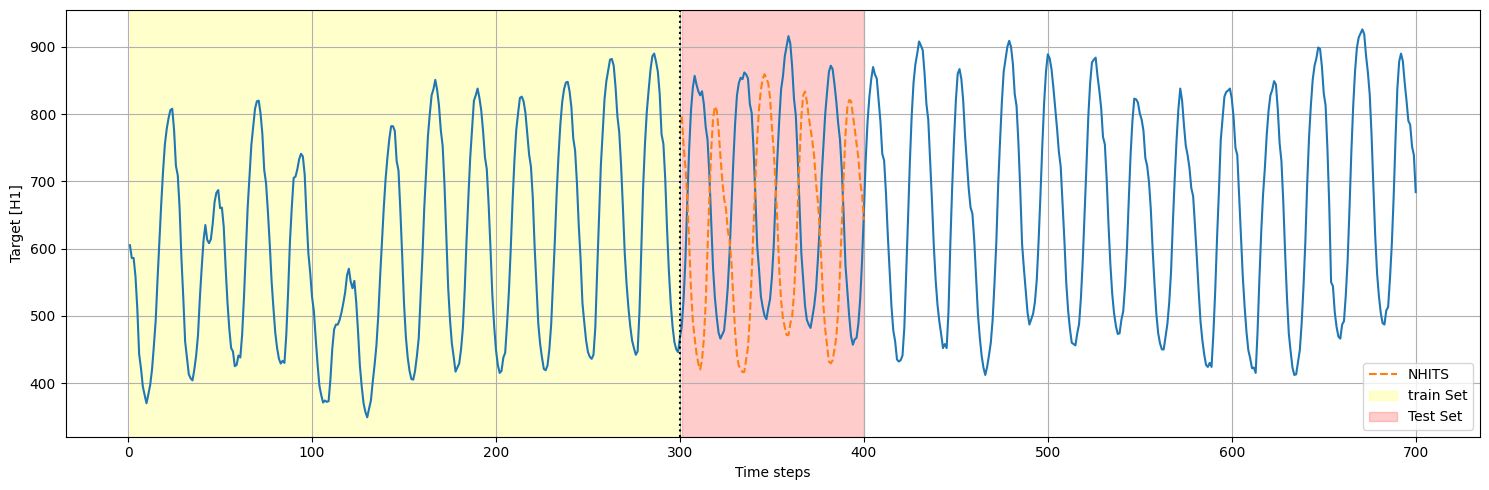

In [30]:
plt.figure(figsize=(15,5))
plt.plot(Y_df['ds'], Y_df['y'])
plt.plot(cv_df_refit.loc[cv_df_refit["cutoff"] == 300, 'ds'], cv_df_refit.loc[cv_df_refit["cutoff"] == 600, 'NHITS'], label='NHITS', ls='--')
# Add highlighted areas for validation and test sets
plt.axvspan(Y_df['ds'].iloc[0], Y_df['ds'].iloc[299], alpha=0.2, color='yellow', label='train Set')
plt.axvspan(Y_df['ds'].iloc[300], Y_df['ds'].iloc[399], alpha=0.2, color='red', label='Test Set')

plt.axvline(x=300, color='black', ls=':')
plt.xlabel('Time steps')
plt.ylabel('Target [H1]')
plt.legend()
plt.tight_layout()
plt.grid()

## method 4: overlapping windows

In [8]:
cv_df_refit_overlap = nf.cross_validation(
    Y_df, 
    n_windows=5, 
    step_size=50, 
    refit=True
)
cv_df_refit_overlap

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params
-----------------------------------------------
0 | loss         | MAE           | 0     
1 | padder_train | ConstantPad1d | 0     
2 | scaler       | TemporalNorm  | 0     
3 | blocks       | ModuleList    | 3.0 M 
-----------------------------------------------
3.0 M     Trainable params
0         Non-trainable params
3.0 M     Total params
11.871    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_steps=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU availab

,unique_id,ds,cutoff,NHITS,y
0,H1,401,400,719.833496,732.0
1,H1,402,400,774.944702,789.0
2,H1,403,400,820.069885,826.0
3,H1,404,400,838.716858,852.0
4,H1,405,400,853.537537,870.0
...,...,...,...,...,...
495,H1,696,600,724.097168,790.0
496,H1,697,600,699.242676,784.0
497,H1,698,600,668.142761,752.0
498,H1,699,600,630.826294,739.0


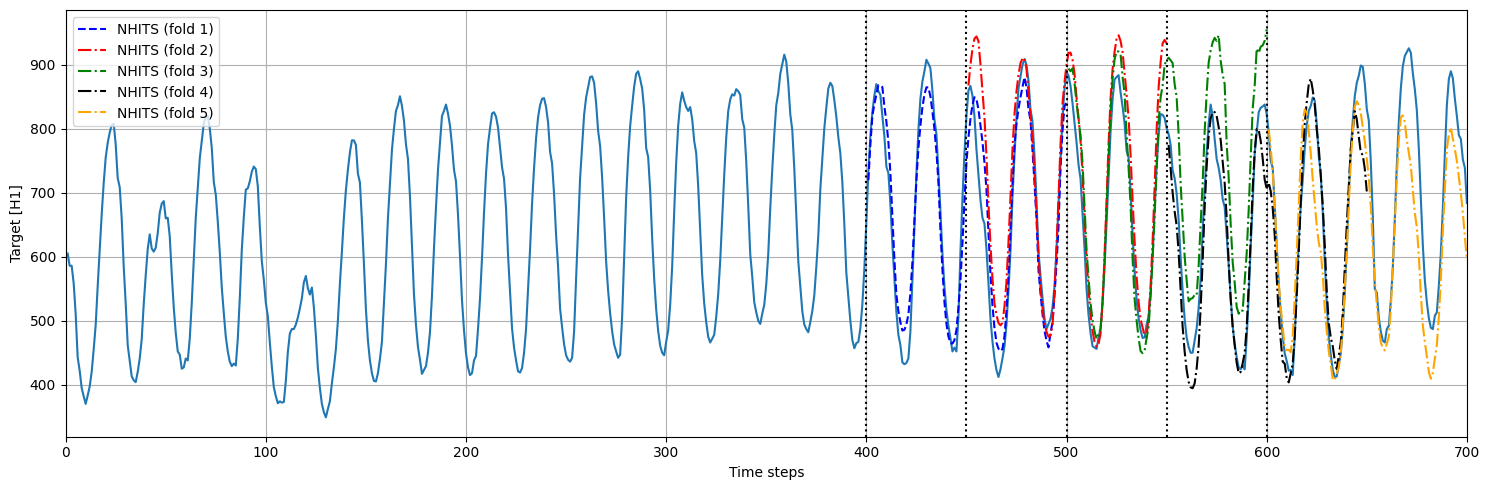

In [10]:
cutoffs = cv_df_refit_overlap['cutoff'].unique()
fold1 = cv_df_refit_overlap.query("cutoff==400")
fold2 = cv_df_refit_overlap.query("cutoff==450")
fold3 = cv_df_refit_overlap.query("cutoff==500")
fold4 = cv_df_refit_overlap.query("cutoff==550")
fold5 = cv_df_refit_overlap.query("cutoff==600")

plt.figure(figsize=(15,5))
plt.plot(Y_df['ds'], Y_df['y'])
plt.plot(fold1['ds'], fold1['NHITS'], label='NHITS (fold 1)', ls='--', color='blue')
plt.plot(fold2['ds'], fold2['NHITS'], label='NHITS (fold 2)', ls='-.', color='red')
plt.plot(fold3['ds'], fold3['NHITS'], label='NHITS (fold 3)', ls='-.', color='green')
plt.plot(fold4['ds'], fold4['NHITS'], label='NHITS (fold 4)', ls='-.', color='black')
plt.plot(fold5['ds'], fold5['NHITS'], label='NHITS (fold 5)', ls='-.', color='orange')

for cutoff in cv_df_refit_overlap['cutoff'].unique():
    plt.axvline(x=cutoff, color='black', ls=':')

plt.xlabel('Time steps')
plt.ylabel('Target [H1]')
plt.xlim(0, 700)
plt.legend()
plt.tight_layout()
plt.grid()

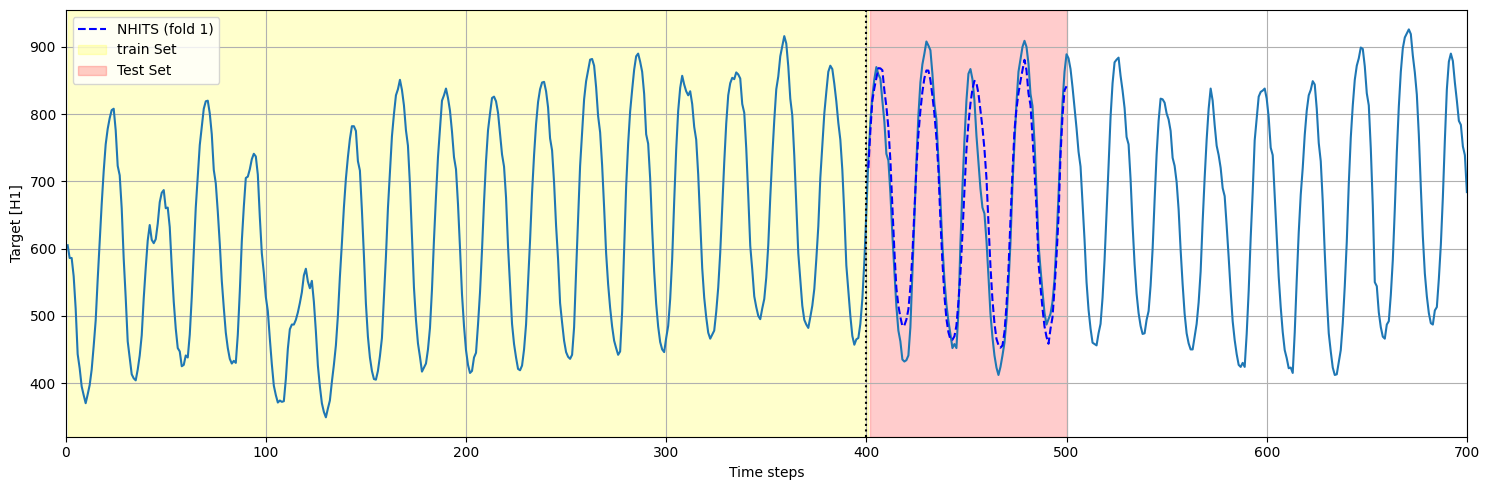

In [20]:
cutoffs = cv_df_refit_overlap['cutoff'].unique()
fold1 = cv_df_refit_overlap.query("cutoff==400")
# fold2 = cv_df_refit_overlap.query("cutoff==450")
# fold3 = cv_df_refit_overlap.query("cutoff==500")
# fold4 = cv_df_refit_overlap.query("cutoff==550")
# fold5 = cv_df_refit_overlap.query("cutoff==600")

plt.figure(figsize=(15,5))
plt.plot(Y_df['ds'], Y_df['y'])
plt.plot(fold1['ds'], fold1['NHITS'], label='NHITS (fold 1)', ls='--', color='blue')
# plt.plot(fold2['ds'], fold2['NHITS'], label='NHITS (fold 2)', ls='-.', color='red')
# plt.plot(fold3['ds'], fold3['NHITS'], label='NHITS (fold 3)', ls='-.', color='green')
# plt.plot(fold4['ds'], fold4['NHITS'], label='NHITS (fold 4)', ls='-.', color='black')
# plt.plot(fold5['ds'], fold5['NHITS'], label='NHITS (fold 5)', ls='-.', color='orange')

# Add highlighted areas for validation and test sets
plt.axvspan(Y_df['ds'].iloc[0], Y_df['ds'].iloc[400], alpha=0.2, color='yellow', label='train Set')
plt.axvspan(Y_df['ds'].iloc[401], Y_df['ds'].iloc[499], alpha=0.2, color='red', label='Test Set')

plt.axvline(x=400, color='black', ls=':')

plt.xlabel('Time steps')
plt.ylabel('Target [H1]')
plt.xlim(0, 700)
plt.legend()
plt.tight_layout()
plt.grid()

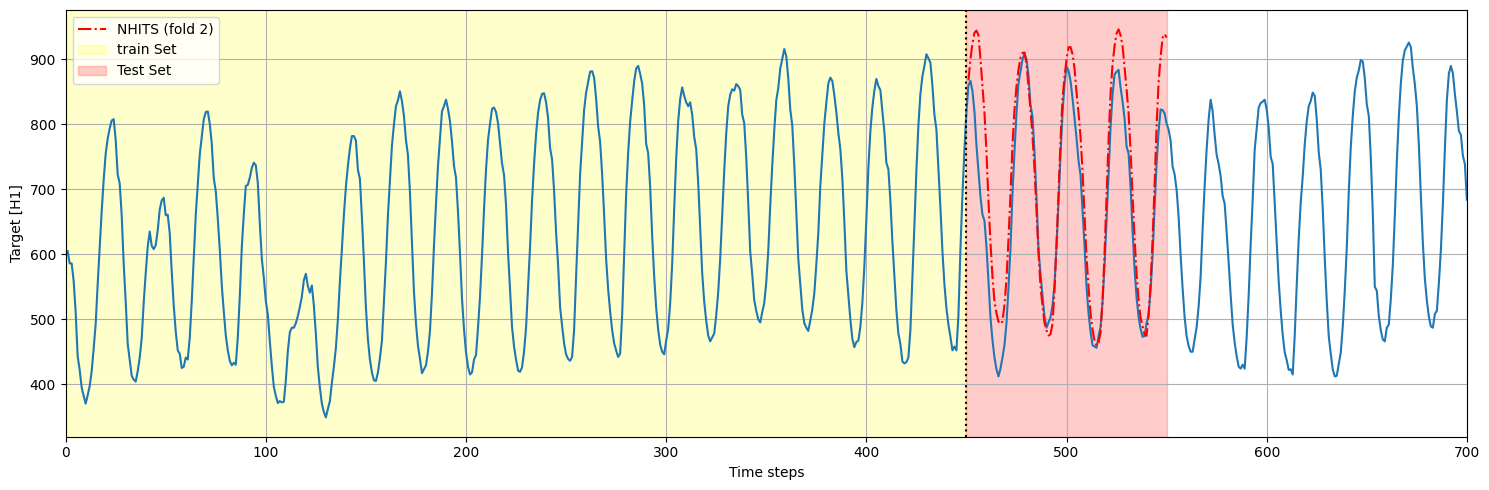

In [19]:
cutoffs = cv_df_refit_overlap['cutoff'].unique()
# fold1 = cv_df_refit_overlap.query("cutoff==400")
fold2 = cv_df_refit_overlap.query("cutoff==450")
# fold3 = cv_df_refit_overlap.query("cutoff==500")
# fold4 = cv_df_refit_overlap.query("cutoff==550")
# fold5 = cv_df_refit_overlap.query("cutoff==600")

plt.figure(figsize=(15,5))
plt.plot(Y_df['ds'], Y_df['y'])
# plt.plot(fold1['ds'], fold1['NHITS'], label='NHITS (fold 1)', ls='--', color='blue')
plt.plot(fold2['ds'], fold2['NHITS'], label='NHITS (fold 2)', ls='-.', color='red')
# plt.plot(fold3['ds'], fold3['NHITS'], label='NHITS (fold 3)', ls='-.', color='green')
# plt.plot(fold4['ds'], fold4['NHITS'], label='NHITS (fold 4)', ls='-.', color='black')
# plt.plot(fold5['ds'], fold5['NHITS'], label='NHITS (fold 5)', ls='-.', color='orange')

# Add highlighted areas for validation and test sets
plt.axvspan(Y_df['ds'].iloc[0], Y_df['ds'].iloc[449], alpha=0.2, color='yellow', label='train Set')
plt.axvspan(Y_df['ds'].iloc[449], Y_df['ds'].iloc[549], alpha=0.2, color='red', label='Test Set')

plt.axvline(x=450, color='black', ls=':')

plt.xlabel('Time steps')
plt.ylabel('Target [H1]')
plt.xlim(0, 700)
plt.legend()
plt.tight_layout()
plt.grid()

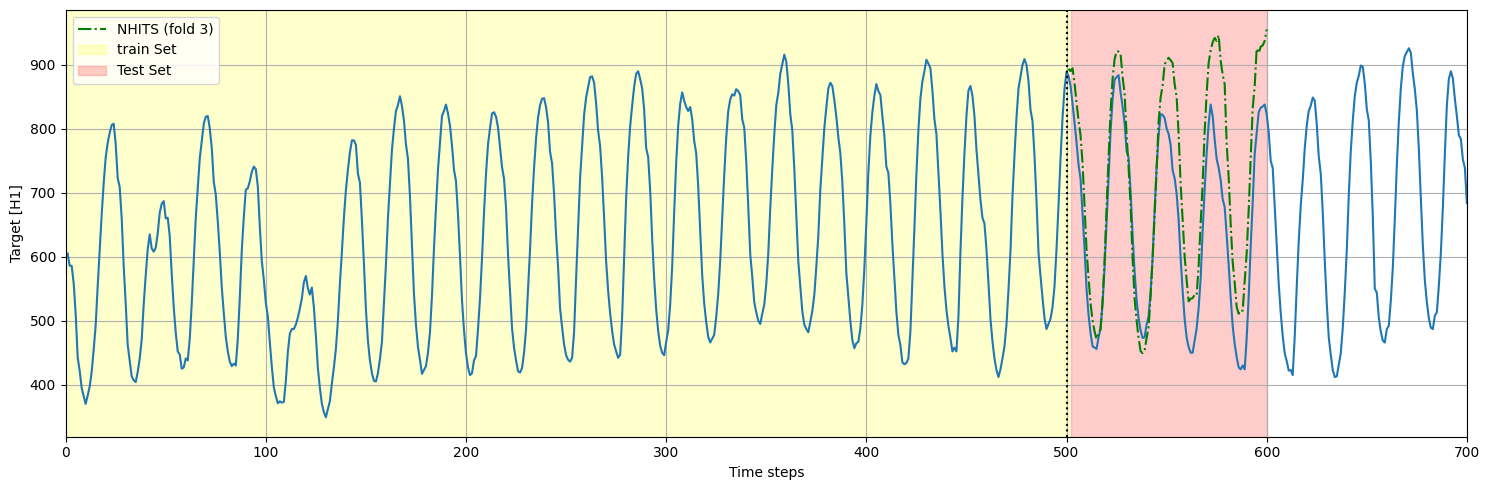

In [16]:
cutoffs = cv_df_refit_overlap['cutoff'].unique()
# fold1 = cv_df_refit_overlap.query("cutoff==400")
# fold2 = cv_df_refit_overlap.query("cutoff==450")
fold3 = cv_df_refit_overlap.query("cutoff==500")
# fold4 = cv_df_refit_overlap.query("cutoff==550")
# fold5 = cv_df_refit_overlap.query("cutoff==600")

plt.figure(figsize=(15,5))
plt.plot(Y_df['ds'], Y_df['y'])
# plt.plot(fold1['ds'], fold1['NHITS'], label='NHITS (fold 1)', ls='--', color='blue')
# plt.plot(fold2['ds'], fold2['NHITS'], label='NHITS (fold 2)', ls='-.', color='red')
plt.plot(fold3['ds'], fold3['NHITS'], label='NHITS (fold 3)', ls='-.', color='green')
# plt.plot(fold4['ds'], fold4['NHITS'], label='NHITS (fold 4)', ls='-.', color='black')
# plt.plot(fold5['ds'], fold5['NHITS'], label='NHITS (fold 5)', ls='-.', color='orange')

# Add highlighted areas for validation and test sets
plt.axvspan(Y_df['ds'].iloc[0], Y_df['ds'].iloc[500], alpha=0.2, color='yellow', label='train Set')
plt.axvspan(Y_df['ds'].iloc[501], Y_df['ds'].iloc[599], alpha=0.2, color='red', label='Test Set')

plt.axvline(x=500, color='black', ls=':')

plt.xlabel('Time steps')
plt.ylabel('Target [H1]')
plt.xlim(0, 700)
plt.legend()
plt.tight_layout()
plt.grid()

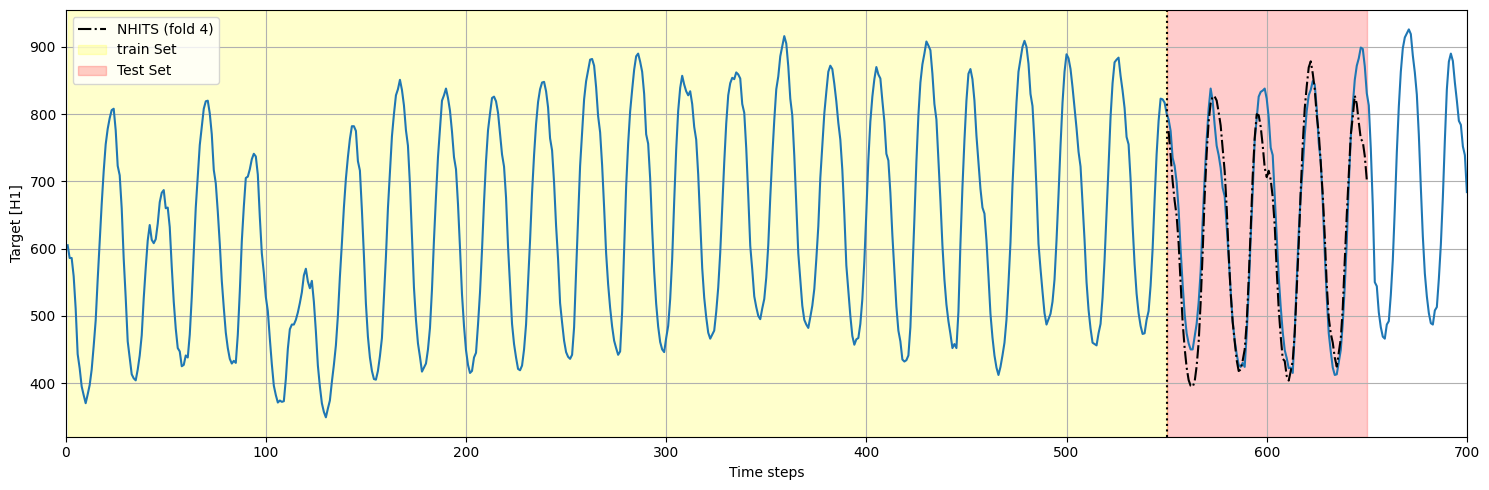

In [14]:
cutoffs = cv_df_refit_overlap['cutoff'].unique()
# fold1 = cv_df_refit_overlap.query("cutoff==400")
# fold2 = cv_df_refit_overlap.query("cutoff==450")
# fold3 = cv_df_refit_overlap.query("cutoff==500")
fold4 = cv_df_refit_overlap.query("cutoff==550")
# fold5 = cv_df_refit_overlap.query("cutoff==600")

plt.figure(figsize=(15,5))
plt.plot(Y_df['ds'], Y_df['y'])

# plt.plot(fold1['ds'], fold1['NHITS'], label='NHITS (fold 1)', ls='--', color='blue')
# plt.plot(fold2['ds'], fold2['NHITS'], label='NHITS (fold 2)', ls='-.', color='red')
# plt.plot(fold3['ds'], fold3['NHITS'], label='NHITS (fold 3)', ls='-.', color='green')
plt.plot(fold4['ds'], fold4['NHITS'], label='NHITS (fold 4)', ls='-.', color='black')
# plt.plot(fold5['ds'], fold5['NHITS'], label='NHITS (fold 5)', ls='-.', color='orange')

# Add highlighted areas for validation and test sets
plt.axvspan(Y_df['ds'].iloc[0], Y_df['ds'].iloc[549], alpha=0.2, color='yellow', label='train Set')
plt.axvspan(Y_df['ds'].iloc[549], Y_df['ds'].iloc[649], alpha=0.2, color='red', label='Test Set')

plt.axvline(x=550, color='black', ls=':')

plt.xlabel('Time steps')
plt.ylabel('Target [H1]')
plt.xlim(0, 700)
plt.legend()
plt.tight_layout()
plt.grid()

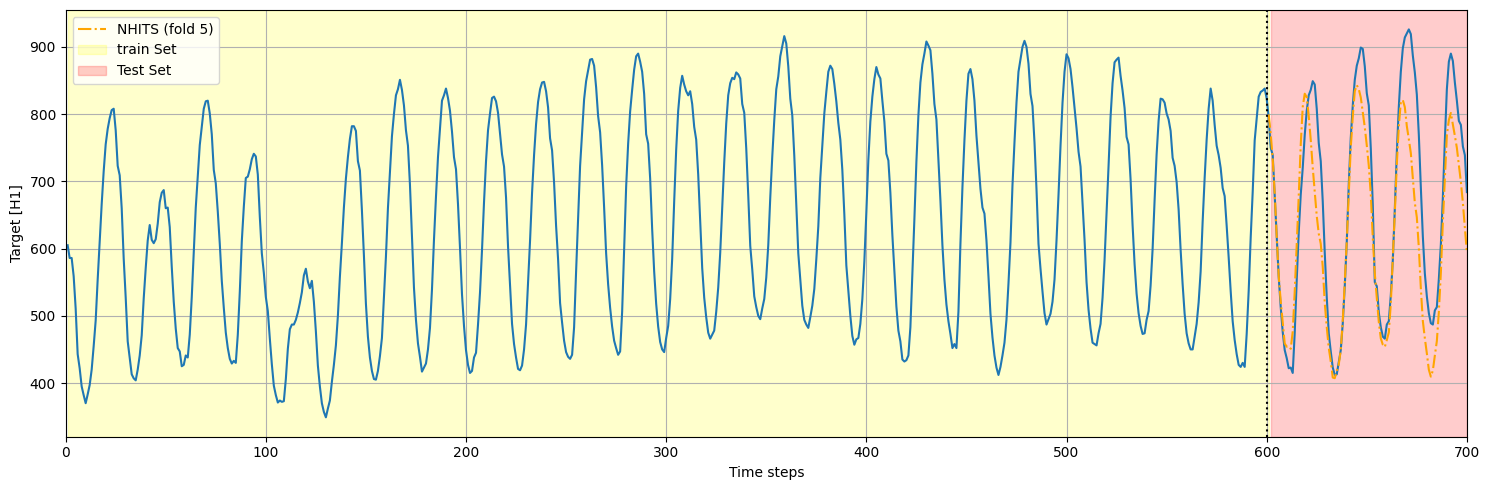

In [13]:
cutoffs = cv_df_refit_overlap['cutoff'].unique()
# fold1 = cv_df_refit_overlap.query("cutoff==400")
# fold2 = cv_df_refit_overlap.query("cutoff==450")
# fold3 = cv_df_refit_overlap.query("cutoff==500")
# fold4 = cv_df_refit_overlap.query("cutoff==550")
fold5 = cv_df_refit_overlap.query("cutoff==600")

plt.figure(figsize=(15,5))
plt.plot(Y_df['ds'], Y_df['y'])

# plt.plot(fold1['ds'], fold1['NHITS'], label='NHITS (fold 1)', ls='--', color='blue')
# plt.plot(fold2['ds'], fold2['NHITS'], label='NHITS (fold 2)', ls='-.', color='red')
# plt.plot(fold3['ds'], fold3['NHITS'], label='NHITS (fold 3)', ls='-.', color='green')
# plt.plot(fold4['ds'], fold4['NHITS'], label='NHITS (fold 4)', ls='-.', color='black')
plt.plot(fold5['ds'], fold5['NHITS'], label='NHITS (fold 5)', ls='-.', color='orange')

# Add highlighted areas for validation and test sets
plt.axvspan(Y_df['ds'].iloc[0], Y_df['ds'].iloc[600], alpha=0.2, color='yellow', label='train Set')
plt.axvspan(Y_df['ds'].iloc[601], Y_df['ds'].iloc[699], alpha=0.2, color='red', label='Test Set')

plt.axvline(x=600, color='black', ls=':')

plt.xlabel('Time steps')
plt.ylabel('Target [H1]')
plt.xlim(0, 700)
plt.legend()
plt.tight_layout()
plt.grid()